# Dog Breed Prediction with CNN

In this tutorial we  are going to create a convolutional neural network for a classification problem. We are going to train our model to figure out what breed a dog is.

Before we get started we need to implement the following libraries:

1. Pandas - Library providing high-performance, easy-to-use data structures and data analysis tools.
2. Numpy - Fundamental package for scientific computing with Python
3. Matplotlib - Python 2D plotting library
4. tqdm - Extensible Progress Bar for Python 
5. keras - Neural-network library
6. mpl_toolkits - provides some basic 3D plotting tools.



In [6]:
# This is to test if the current notebook is using a GPU when running the cells
# There is going to be a lot of training involved so it is recommended to turn
# on the GPU in: Runtime -> Change runtime types -> Hardware accelerator -> GPU

# When that is done, running this cell should output: '/device:GPU:0'
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from __future__ import print_function
from tqdm import tqdm
import pandas as pd         
import numpy as np 
import cv2 as cv2            
import matplotlib.pyplot as plt    
import tqdm as tqdm

from keras.layers import Activation, Convolution2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.applications import InceptionV3, ResNet50, Xception
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.random import seed
from random import randint

In [8]:
# Download the zip folder
!wget "https://ai-camp-content.s3.amazonaws.com/dog-breeds.zip"

--2019-08-23 11:19:31--  https://ai-camp-content.s3.amazonaws.com/dog-breeds.zip
Resolving ai-camp-content.s3.amazonaws.com (ai-camp-content.s3.amazonaws.com)... 52.216.228.232
Connecting to ai-camp-content.s3.amazonaws.com (ai-camp-content.s3.amazonaws.com)|52.216.228.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724224611 (691M) [application/zip]
Saving to: ‘dog-breeds.zip’

dog-breeds.zip      100%[===================>] 690.67M  13.8MB/s    in 52s     

2019-08-23 11:20:23 (13.4 MB/s) - ‘dog-breeds.zip’ saved [724224611/724224611]



In [9]:
# Unzip the folder
!unzip dog-breeds.zip

Archive:  dog-breeds.zip
  inflating: labels.csv              
   creating: test/
  inflating: test/266490a2b053a4a3bf68e779f28fb5a9.jpg  
  inflating: test/dae9fd18836d8df20989ef0101771d4b.jpg  
  inflating: test/079a40f22b0fad9a66f76797b62bb930.jpg  
  inflating: test/ab8462f9a501d362041d47582fddc9ad.jpg  
  inflating: test/8895089b432e020cc42e6262b5a1c2dd.jpg  
  inflating: test/985ae7fc271ac4a0d131e546c0f95bb6.jpg  
  inflating: test/77c1ab99cffb817d54fb14f229aeb118.jpg  
  inflating: test/ad7e50abca9b7c6a88b63946c5bbe493.jpg  
  inflating: test/d61a09cecf56666cdb315ebce4b93c43.jpg  
  inflating: test/cb120c57904e8c0694bbe259c58a873c.jpg  
  inflating: test/10863e6d9d1cb526cc9d90f30a585719.jpg  
  inflating: test/43cb5f3a505d710bd16e0a0d583a781b.jpg  
  inflating: test/a5aa4e972242a61829ad10b220a12c64.jpg  
  inflating: test/abca35eb197f260e4e348156818bf930.jpg  
  inflating: test/28950f53443e40e5a704a8cb5a1e1d35.jpg  
  inflating: test/326e3c2a0a47f79ad1a87ca5c2f84d79.jpg  
  infl

In [10]:
# Read the labels.csv file into a dataframe
df = pd.read_csv('/content/labels.csv')

# It contains the ID of the image and the breed of the dog in the image - display the first 5 rows 
df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Reduce the Amount of Data
Since there is a lot of images to work with, we are going to have to reduce the amount that we will be using so we can get faster results and also train with more even spread of classes. 

To Do:
- Define the desired image height and width for every image we pass in.
- Define the amount of breeds you want to work with and reduce the dataframe to only those breeds.
- Use one hot encoding to get a unique identifier for each breed.
- Create a function to transform the one hot encode back to it's original label

In [0]:
NUM_CLASSES = 16
IMG_WIDTH = 224   
IMG_HEIGHT = 224

# Create a list called selected_breeds which will hold the top 16 dog breeds - you might want to use the .groupby() function on the df to group by breed 
selected_breeds = list(df.groupby('breed').count().sort_values('id', ascending = False).head(16).index)

# We want the records that are associated with the breeds held 
# in selected_breeds - to do this try using the .isin() function on the dataframe and pass in the selected breeds
df_sub_train = df[df['breed'].isin(selected_breeds)]

# A series object is a like a mix between a dataframe and 
# and array. Use pd.Series() to convert df_sub_train['breed'] into a series
# In other words it is an array with axis labels or titles. 
targets = pd.Series(df_sub_train['breed'])


# one_hot is a dataframe where the breeds have been one hot encoded. 
# Each breed is given a unique label that can be used to easily identify
# each breed.
# To do this we can use pd.get_dummies and pass in out targets
one_hot = pd.get_dummies(targets)


# Create a 2D array where each array is an identifier for each breed in relation to the
# remaining images included in the top 16 breeds- This can be done by createing a numpy array.
one_hot_labels = np.asarray(one_hot)


In [0]:
# One Hot Encode the classes
data = np.array(selected_breeds)
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(data.reshape(-1,1))

# Function to transform the one hot encode back to its original label
# This will be used for transforming predictions in actual labels
def one_hot_to_label(prediction):
    k = 0
    for i in range(0, len(onehot_encoded)):
        if np.array_equal(prediction, onehot_encoded[i]):
            break
        k = k + 1
    return selected_breeds[k]

In [0]:
# Function to read an image from the train or test folder and resize it accordingly
def read_img(img_id, train_or_test):
    img = cv2.imread(train_or_test + '{}.jpg'.format(img_id))
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) 

## Load the Images and Labels into Arrays
We need a way to access each image in the order that they are in the table. Create a for loop and load each image in using the table with each image name associated with its breed and ID.

To Do:
- Create a for loop that loads in each image, image id and label to their individual array

In [14]:
images = []
image_ids = []
classes = []

# Load all the images and append them in an array. 
# Also append the class and id for each image in arrays.
# Note: This might take a few minutes, You can see the progress of the for loop
# with the tqdm library -- https://tqdm.github.io/

# TODO:
for img_id, breed in tqdm.tqdm(df_sub_train.values):
  images.append(read_img(img_id, 'train/'))
  image_ids.append(img_id)
  classes.append(breed)

100%|██████████| 1777/1777 [00:04<00:00, 372.59it/s]


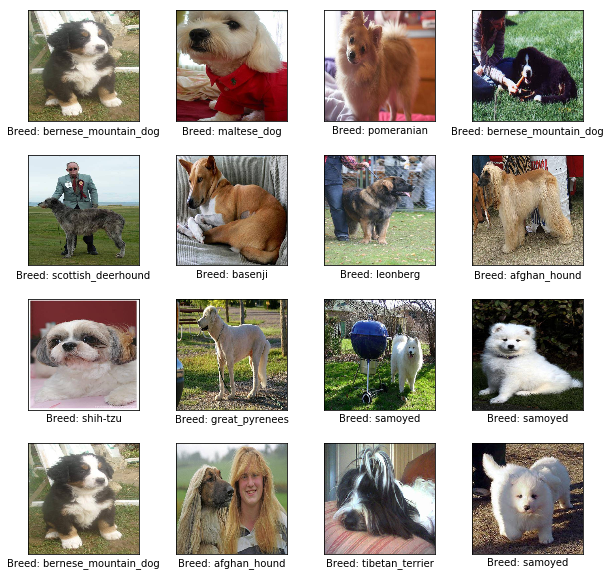

In [15]:
# Helper-function for plotting images
def plot_images(images, classes):
    assert len(images) == len(classes) == NUM_CLASSES
    
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(4, 4, figsize=(10,10),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(10)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Display an image from each breed
random_numbers = [randint(0, len(images)) for p in range(0,NUM_CLASSES)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]

plot_images(images_to_show, classes_to_show)

## Split the Data
Split the data into training, testing and validation data.

To Do:
- Split the data using train_test_split

In [0]:
# Let's store the image ids as X and the one hot labels as Y
X = np.array(image_ids)
Y = np.array(one_hot_labels)

# Split the train and test data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)


In [20]:
x_train_images = []
x_test_images = []

# After splitting the data in their individual arrays, you can load the images
# for each of the image ids stored in the x_train/x_test/x_val variables

#The training images
for img_id in tqdm.tqdm(x_train):
  x_train_images.append(read_img(img_id, 'train/'))
  
#The testing images
for img_id in tqdm.tqdm(x_test):
  x_test_images.append(read_img(img_id, 'train/'))

100%|██████████| 356/356 [00:00<00:00, 392.13it/s]


In [21]:
x_train_images[0]

array([[[121, 151, 138],
        [118, 148, 135],
        [128, 158, 145],
        ...,
        [ 64,  64,  46],
        [ 64,  65,  45],
        [ 72,  73,  53]],

       [[114, 145, 134],
        [100, 132, 121],
        [110, 142, 131],
        ...,
        [ 57,  57,  39],
        [ 55,  55,  37],
        [ 62,  63,  43]],

       [[108, 140, 130],
        [ 96, 127, 117],
        [100, 132, 122],
        ...,
        [ 61,  61,  44],
        [ 58,  58,  40],
        [ 64,  65,  46]],

       ...,

       [[ 33,  65,  71],
        [ 31,  61,  72],
        [ 33,  59,  75],
        ...,
        [ 33,  42,  56],
        [ 38,  46,  63],
        [ 42,  49,  68]],

       [[ 34,  66,  72],
        [ 31,  61,  72],
        [ 33,  59,  75],
        ...,
        [ 33,  42,  56],
        [ 34,  42,  59],
        [ 41,  48,  67]],

       [[ 43,  75,  81],
        [ 39,  69,  80],
        [ 41,  66,  83],
        ...,
        [ 47,  56,  70],
        [ 40,  48,  65],
        [ 51,  58,  77]]

# Using existing models

## Resnet 50
We are going to use a pre-trained model initially to see how well it performs on our dataset. 

Plan of action:
- Define the Resnet50 model
- Plot the accuracies of the model on a grid for some images from our dataset


In [22]:
# Get the ResNet50 model
model = ResNet50(weights='imagenet');

W0823 11:23:25.233184 139680016791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 11:23:25.236012 139680016791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 11:23:25.250244 139680016791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0823 11:23:25.276511 139680016791424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 11:23:25.277331

102858752/102853048 [==============================] - 8s 0us/step


40960/35363 [==================================] - 0s 0us/step


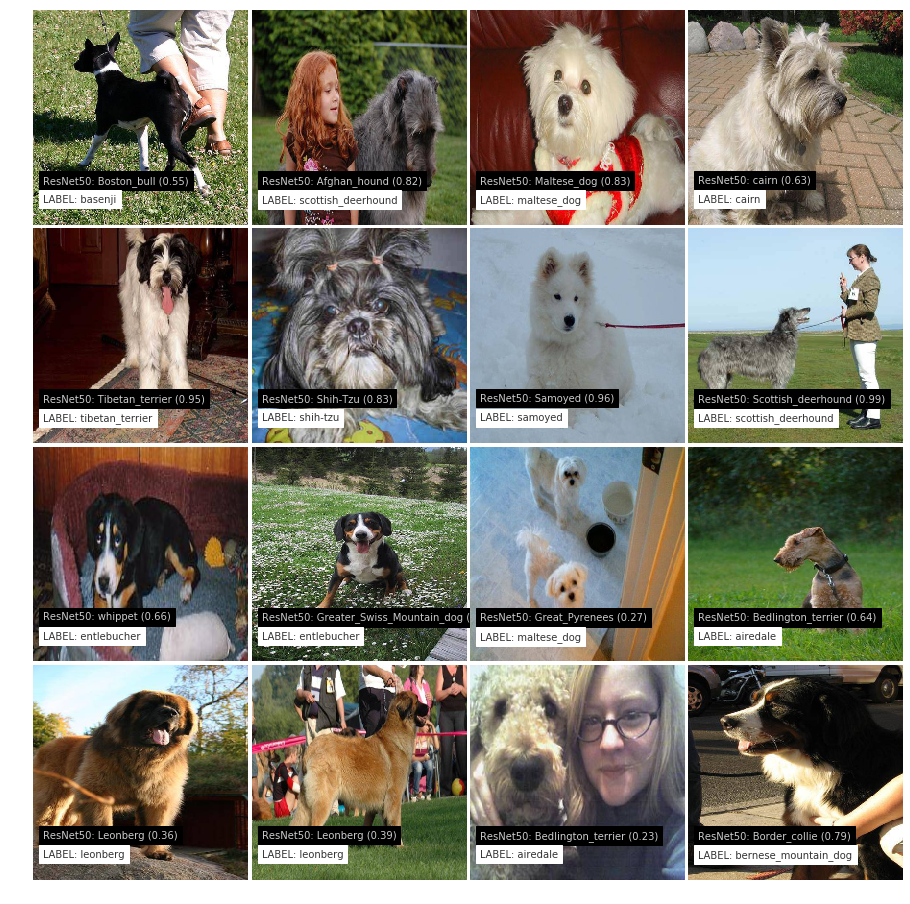

In [23]:
# Setup the grid and figures for displaying 16 images 
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)

i = 0
# Get some of the images from our dataset and display them alongside with their label and prediction
for (img_id, breed) in df_sub_train.values[0:16]:
    ax = grid[i]
    # Read the image into an array
    img = read_img(img_id, 'train/')
    
    # Display the image on the grid
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='hsv') 
    
    # The shape of the image needs to be (1, 224, 224, 3) when input in the model
    # which is why we reshape it from (224, 224, 3)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    
    # Get the predicted label of the input image
    prediction = model.predict(x)
    
    # Transform the one hot label to it's original class name
    one_hot_label, imagenet_class_name, prob = decode_predictions(prediction, top=1)[0][0]
    
    # Display the true label and predicted label on the image at the specified coordinates
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
    i = i + 1
plt.show()

## InceptionV3
This time we are going to use the InceptionV3 pre-trained model and build up our own layers on top of it. This allows us to use a model which is already pretty accurate by itself and then train new weights that are learned from our particular dataset. 

To Do:
- Define an InceptionV3 model 
- Build the following layers on top of the pre-trained model's outputs: 
        Flatten
        Dense
        Droput
        Dense
- Define a copy of the model with an extra Dense layer which will provide us with the predictions
- Compile the model
- Train the model with your training data, validation data and a set amount of epochs 
- Display the images and their labels and predicted labels similar to Resnet 50

In [0]:
# Get the InceptionV3 model without it's fully connected layer and load the weights trained on 
# the imagenet dataset
inception_bottleneck = InceptionV3(include_top=False, 
                             weights='imagenet', 
                             input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
                             classes=NUM_CLASSES)

#Make layers trainable 
for layer in inception_bottleneck.layers:
  layer.trainable=True

In [0]:
# TODO:
x = inception_bottleneck.output

#Adding layers to the network 
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
#x = Dense(256, activation = 'sigmoid')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)
final_model = Model(inputs=[inception_bottleneck.input], outputs = [predictions])

final_model.compile(optimizer='SGD',
                 loss = 'categorical_crossentropy',
                 metrics = ['categorical_accuracy'])

final_model.fit(x = x_train_images, 
               y = y_train,
               epochs = 10, 
               validation_data = (x_test_images, y_test))

ValueError: ignored

## Exercises

1. Build another model but this time with a different pre-trained model and your own layers. You can  also augment the data as we did in the Cats vs Dogs exercise for further improvements. (Possible models, **VGG16**, **Xception**)

In [0]:
# TODO:
